<a href="https://colab.research.google.com/github/ranzan97/Tensorflow/blob/main/Transfer_Learning_Oxford_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Step 1: Load the Oxford Flowers Dataset
import tensorflow_datasets as tfds

In [ ]:
# Load the dataset
dataset_name = 'oxford_flowers102'
(train_ds, val_ds, test_ds), metadata = tfds.load(
    dataset_name,
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.Z9WBKM_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.Z9WBKM_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.Z9WBKM_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
num_classes = metadata.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Number of classes: 102


In [ ]:
# Step 2: Preprocess the dataset
def preprocess_image(image, label, img_size=(224, 224)):
    # Resize and normalize the image
    image = tf.image.resize(image, img_size)
    image /= 255.0  # Normalize to [0, 1]
    return image, label

In [ ]:
batch_size = 32

In [ ]:
# Apply preprocessing and batching
train_ds = train_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Step 3: Load a pre-trained model (EfficientNetB0)
base_model = EfficientNetB0(
    include_top=False,  # Exclude the top classification layer
    weights='imagenet',  # Use pre-trained weights from ImageNet
    input_shape=(224, 224, 3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model's layers (we'll only train the top layers initially)
base_model.trainable = False

In [ ]:
# Step 4: Build the transfer learning model with L2 regularization
model = models.Sequential([
    base_model,  # Pre-trained base model
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Add L2 regularization
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Adjusted learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Step 5: Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [ ]:
print("Training the top layers...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Increased epochs
    callbacks=[early_stopping]
)

Training the top layers...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.0072 - loss: 8.8831 - val_accuracy: 0.0167 - val_loss: 8.7146
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.0853 - loss: 8.3771 - val_accuracy: 0.0127 - val_loss: 8.5462
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.1921 - loss: 7.9442 - val_accuracy: 0.0167 - val_loss: 8.3974
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.3803 - loss: 7.4121 - val_accuracy: 0.0265 - val_loss: 8.2557
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.4649 - loss: 6.8500 - val_accuracy: 0.0431 - val_loss: 8.0667
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.5818 - loss: 6.2546 - val_accuracy: 0.1196 - val_loss: 7.4953
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.6526 - loss: 5.7730 - val_accuracy: 0.0931 - val_loss: 7.5099
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.7157 - los

In [ ]:
# Step 6: Fine-tune the entire model (unfreeze selectively)
print("Fine-tuning the entire model...")
base_model.trainable = True  # Unfreeze the base model

Fine-tuning the entire model...


In [ ]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continue training with the unfrozen base model
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Reduced epochs for fine-tuning
    callbacks=[early_stopping]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9929 - loss: 2.4343 - val_accuracy: 0.7588 - val_loss: 3.3727
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.9929 - loss: 2.4311 - val_accuracy: 0.7912 - val_loss: 3.2667
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.9947 - loss: 2.4253 - val_accuracy: 0.8078 - val_loss: 3.2243
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9928 - loss: 2.4211 - val_accuracy: 0.8206 - val_loss: 3.1888
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.9933 - loss: 2.4405 - val_accuracy: 0.8235 - val_loss: 3.1642
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9952 - loss: 2.4210 - val_accuracy: 0.8324 - val_loss: 3.1640
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.9908 - loss: 2.4349 - val_accuracy: 0.8324 - val_loss: 3.1495
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 0.9922 - loss: 2.4184 - val_accuracy: 0.8

In [ ]:
# Step 7: Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.7922 - loss: 3.2709
Test Loss: 3.255854845046997
Test Accuracy: 0.7932997345924377


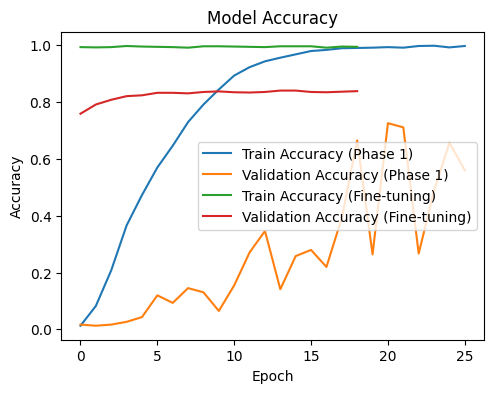

In [ ]:
# Step 8: Visualize Training Results
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy (Phase 1)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Phase 1)')
plt.plot(history_fine.history['accuracy'], label='Train Accuracy (Fine-tuning)')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


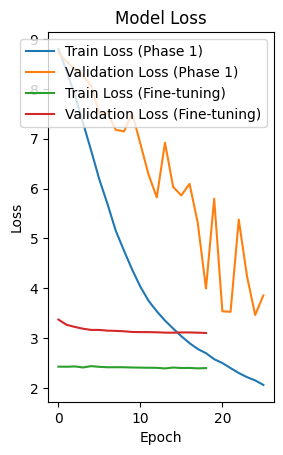

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (Phase 1)')
plt.plot(history.history['val_loss'], label='Validation Loss (Phase 1)')
plt.plot(history_fine.history['loss'], label='Train Loss (Fine-tuning)')
plt.plot(history_fine.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
# Step 9: Make predictions on new data
def predict_image_class(model, img_path, class_names, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class[0]]
    confidence = np.max(predictions) * 100
    return predicted_class_name, confidence


I provided this picture to test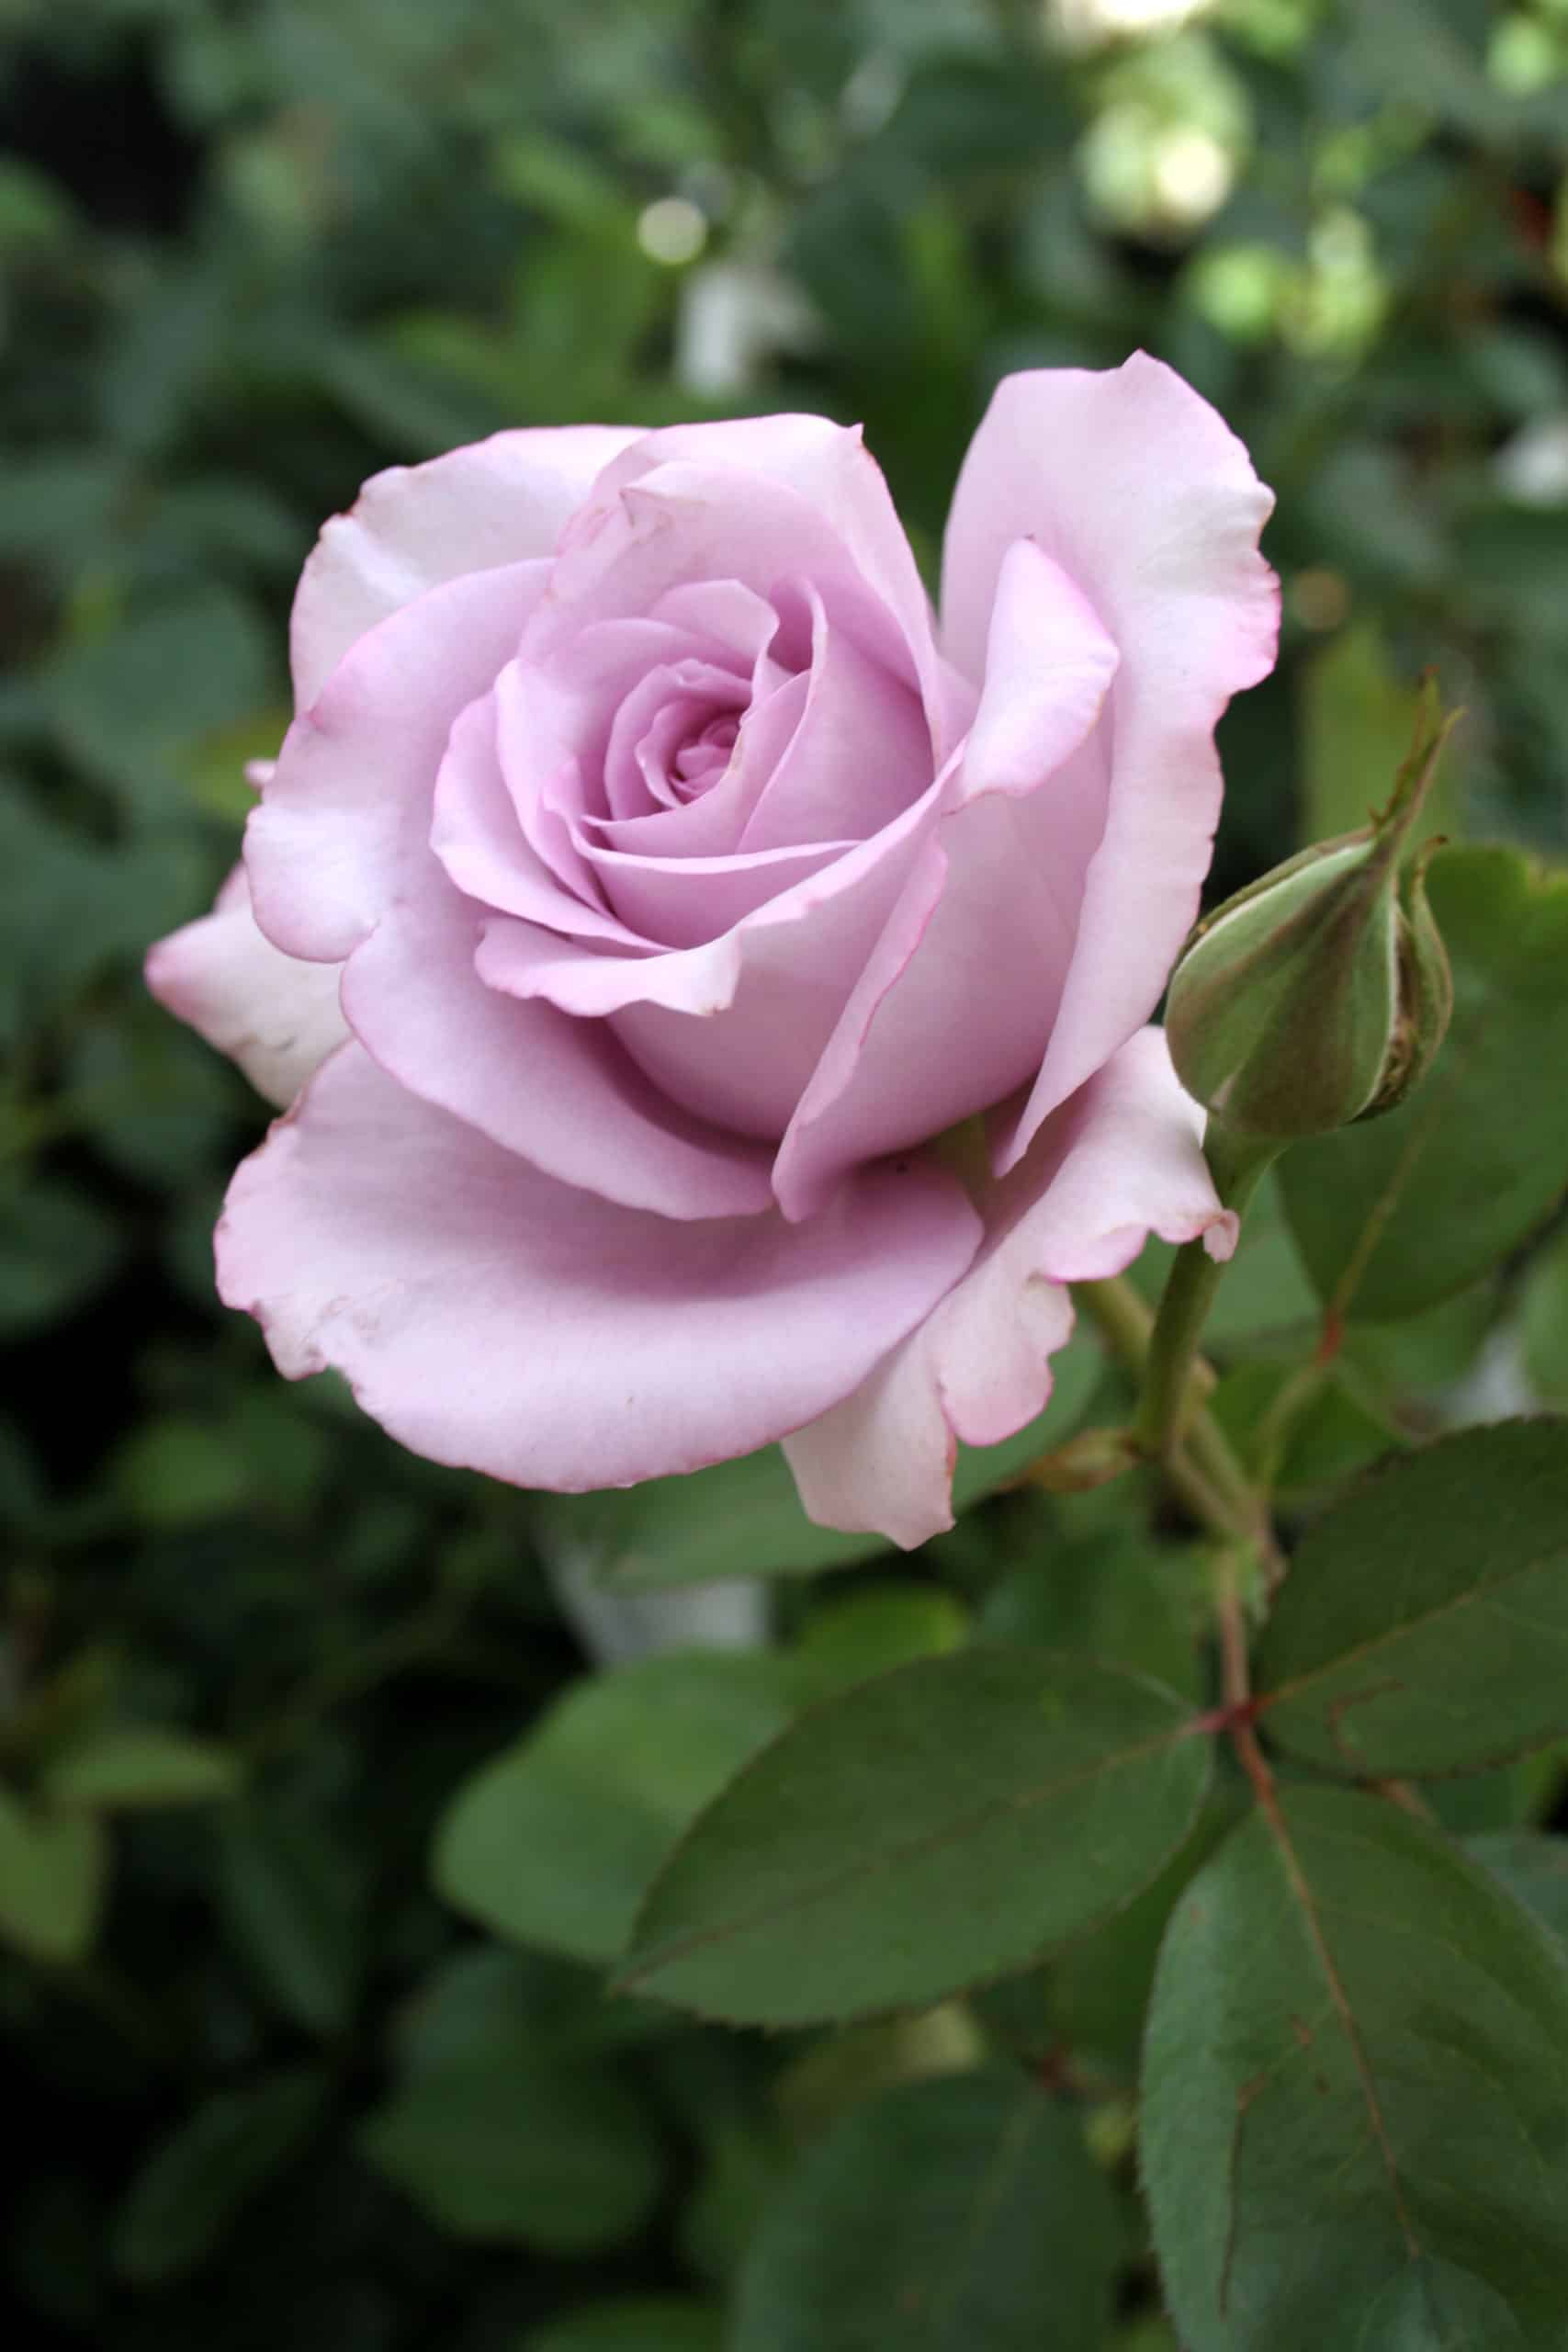

In [ ]:
# Example prediction
class_names = metadata.features['label'].names
example_image_path = '/content/rose.jpg'  # Replace with your image path
predicted_class_name, confidence = predict_image_class(model, example_image_path, class_names)
print(f"Predicted class: {predicted_class_name}, Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted class: rose, Confidence: 88.25%
